
## Description

The tas is to build and train a multimodal deep neural network for emotion detection using tf.keras/pytorch on the FER2013 dataset, which contains more than 28000 images. The images are automatically gathered, so there can be mislabeled or bad quality samples as well. 

Every image has a single label from the following list: Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral.

## What must be done

Train 2 separate models using the original imbalanced and balanced data. Balacing can be done by resampling (undersampling the majority and oversampling the minority classes) or by loss function weighting (bigger error on minority samples).


## Preprocess

* Preprocess the data and visualize samples
  * gather the images, separate the train-valid-test subsets (Training, PublicTest, PrivateTest)
  * plot label histogram
  * plot few images in respective classes



In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import random
import scipy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, callbacks 
import seaborn as sns


In [ ]:
AllData = pd.read_csv("./fer2013.csv")

In [ ]:
##pixel string to array
def pixel_string_to_array(x):
  data_arr = np.fromstring(x, sep=' ').reshape((48,48))
  return data_arr

In [ ]:
Training=AllData[AllData['Usage']=='Training']
PublicTest=AllData[AllData['Usage']=='PublicTest']
PrivateTest=AllData[AllData['Usage']=='PrivateTest']

In [ ]:
x_Training, y_Training = Training['pixels'], Training['emotion']
x_PrivateTest, y_PrivateTest = PrivateTest['pixels'], PrivateTest['emotion']
x_PublicTest, y_PublicTest = PublicTest['pixels'], PublicTest['emotion']

In [ ]:
x_Training = x_Training.apply(pixel_string_to_array).to_numpy()
x_PrivateTest = x_PrivateTest.apply(pixel_string_to_array).to_numpy()
x_PublicTest = x_PublicTest.apply(pixel_string_to_array).to_numpy()

In [ ]:
x_Training=np.stack(x_Training, 0)
x_PrivateTest=np.stack(x_PrivateTest, 0)
x_PublicTest=np.stack(x_PublicTest, 0)

In [ ]:
x_PublicTest=np.expand_dims(x_PublicTest,axis=3)
x_Training=np.expand_dims(x_Training,axis=3)
x_PrivateTest=np.expand_dims(x_PrivateTest,axis=3)

In [ ]:
#x_Training = np.repeat(x_Training, 3,axis=3)
#x_PrivateTest = np.repeat(x_PrivateTest, 3,axis=3)
#x_PublicTest = np.repeat(x_PublicTest, 3,axis=3)

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

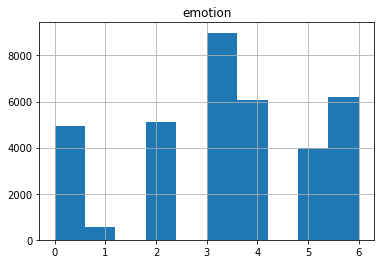

In [ ]:
#emotion_dict = {0: "Anger", 1: "Disgust", 2: "Fear", 3: "Happiness", 4: "Sadness", 5: "Surprise", 6: "Neutral"}

AllData.hist(column='emotion');
AllData['emotion'].value_counts()

In [ ]:
def draw_images(imgs, labels, class_to_draw):
    arr = np.where(labels == class_to_draw)
    x = random.randint(0, len(arr[0])-1) 
    img=imgs[arr[0][x]]
 
    img = np.repeat(img, 3,axis=2)
    imgplot = plt.imshow(image.array_to_img(img))


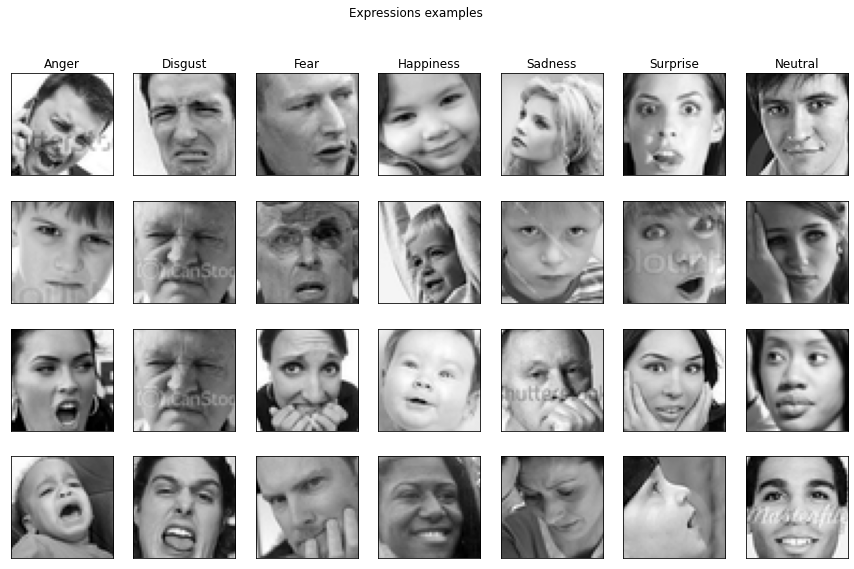

In [ ]:
emotion_dict = {0: "Anger", 1: "Disgust", 2: "Fear", 3: "Happiness", 4: "Sadness", 5: "Surprise", 6: "Neutral"}
plt.figure(figsize=[15, 9])

plt.suptitle('Expressions examples')
for k in range(4):
  for j in range(7):
    plt.subplot(4,7, (k*7)+j+1)
    plt.xticks([])
    plt.yticks([])
    if k==0:
      plt.title(emotion_dict[j])
    draw_images(x_Training, y_Training, j)


##Define train-valid-test dataloaders
  * augment and normalize the input images

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=20,
                            width_shift_range=0.13,
                            height_shift_range=0.13,
                            zoom_range=0.1,
                            horizontal_flip=True,
                             )

datagen2 = ImageDataGenerator(rescale=1./255,
                             ) 

batch_size_test=37 
#37*97
batch_size_train=128

 
x_public_generator = datagen2.flow(
        x_PublicTest, y_PublicTest,
        shuffle=False,
        seed=22,
        batch_size=batch_size_test)

x_private_generator = datagen2.flow(
        x_PrivateTest, y_PrivateTest,
        seed=22,
        batch_size=batch_size_test) 

x_training_generator = datagen.flow(
        x_Training, y_Training,
        seed=22,
        batch_size=batch_size_train)

##Define and train a model
  * define a model
  * define the loss function, optimizer
  * use early stopping and a learning rate scheduler
  * train the model using the training and validation subsets
  * plot the training/validation curve

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=(48,48,1)))
model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(256, (3, 3)))
model.add(layers.Conv2D(256, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024,kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(1024,kernel_initializer='he_uniform'))

model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512))
model.add(layers.Dense(7, activation='softmax'))
 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


In [ ]:
es = callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)
lrd = callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)
history = model.fit(x_training_generator,
                    epochs=60,
                   validation_data=x_private_generator, 
                   validation_steps=(3589/batch_size_test),
                   callbacks=[es,lrd]
                    )

Epoch 1/60
225/225 [==============================] - 28s 110ms/step - loss: 2.3502 - accuracy: 0.2294 - val_loss: 1.8827 - val_accuracy: 0.2449
Epoch 2/60
225/225 [==============================] - 24s 106ms/step - loss: 1.7577 - accuracy: 0.3004 - val_loss: 1.6752 - val_accuracy: 0.3427
Epoch 3/60
225/225 [==============================] - 24s 106ms/step - loss: 1.5943 - accuracy: 0.3757 - val_loss: 1.6045 - val_accuracy: 0.3633
Epoch 4/60
225/225 [==============================] - 24s 106ms/step - loss: 1.4534 - accuracy: 0.4414 - val_loss: 1.3786 - val_accuracy: 0.4773
Epoch 5/60
225/225 [==============================] - 24s 107ms/step - loss: 1.3660 - accuracy: 0.4771 - val_loss: 1.5658 - val_accuracy: 0.4338
Epoch 6/60
225/225 [==============================] - 24s 107ms/step - loss: 1.3092 - accuracy: 0.5009 - val_loss: 1.2953 - val_accuracy: 0.5029
Epoch 7/60
225/225 [==============================] - 24s 107ms/step - loss: 1.2558 - accuracy: 0.5220 - val_loss: 1.3782 - val_ac

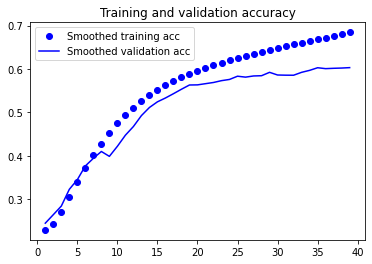

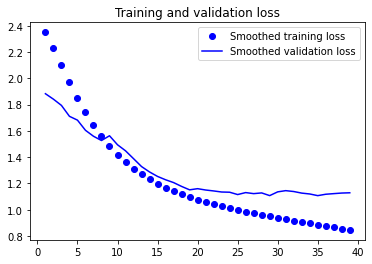

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Evaluation
  * evaluate the model on the test set
  * print/plot classification results and confusion matrix
  * visualize some misclassified samples

In [ ]:
test_loss, test_acc = model.evaluate(x_public_generator, steps=(3589/batch_size_test))
print('test acc:', test_acc)

97/97 [==============================] - 1s 14ms/step - loss: 1.0545 - accuracy: 0.6180
test acc: 0.6179994344711304


In [ ]:
x_public_generator.reset()
pred = model.predict(x_public_generator)

y_pred = np.argmax(pred, axis=1)

print('Confusion Matrix:\n')
print(pd.DataFrame(confusion_matrix(y_PublicTest, y_pred)))
print('\n\n\nClassification report:\n')
print(classification_report(y_PublicTest, y_pred))


Confusion Matrix:

     0   1    2    3    4    5    6
0  219   6   34   35   71   17   85
1   16  21    2    6    6    0    5
2   38   2  167   35  115   44   95
3   17   0   10  788   12   19   49
4   55   4   43   39  336   14  162
5   18   3   30   23    5  317   19
6   33   5   13   67  109   10  370



Classification report:

              precision    recall  f1-score   support

           0       0.55      0.47      0.51       467
           1       0.51      0.38      0.43        56
           2       0.56      0.34      0.42       496
           3       0.79      0.88      0.83       895
           4       0.51      0.51      0.51       653
           5       0.75      0.76      0.76       415
           6       0.47      0.61      0.53       607

    accuracy                           0.62      3589
   macro avg       0.59      0.56      0.57      3589
weighted avg       0.62      0.62      0.61      3589



In [ ]:
basis = {'image': [],
	'correct': [],
	'guess': []}

misses = pd.DataFrame(basis)

for i in range(3589):
  if y_PublicTest[i+28709]!=y_pred[i]:
    new_row = {'image':x_PublicTest[i], 'correct':y_PublicTest[i+28709], 'guess':y_pred[i]}
    misses = misses.append(new_row, ignore_index=True)

#print(misses.head())
#emotion_dict = {0: "Anger", 1: "Disgust", 2: "Fear", 3: "Happiness", 4: "Sadness", 5: "Surprise", 6: "Neutral"}
 

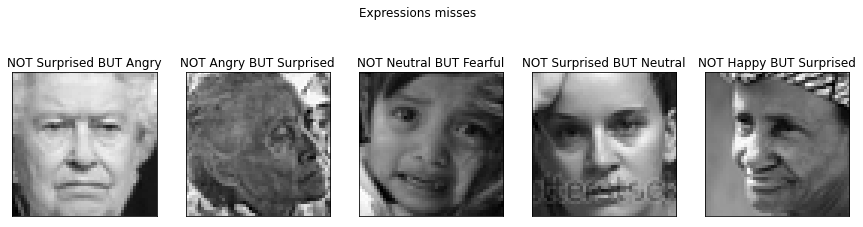

In [ ]:
plt.figure(figsize=[15, 4])
plt.suptitle('Expressions misses')
rndm = random.randint(0, len(misses['image'])-10) 
for j in range(5):
  plt.subplot(1,5, j+1)
  plt.xticks([])
  plt.yticks([])
  plt.title('NOT '+(emotion_dict[misses.at[j+rndm, 'guess'] ])+' BUT '+(emotion_dict[misses.at[j+rndm, 'correct'] ]))
  img = np.repeat(misses.at[j+rndm, 'image'], 3,axis=2)
  plt.imshow(image.array_to_img(img))

##Balancing
  * Class weights

In [ ]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(y_Training), 
               y_Training)

#print(class_weights)
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
class_weights_dict = dict(enumerate(class_weights))                 
print(class_weights_dict)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8491274770777877, 5: 1.293372978330405, 6: 0.8260394187886635}


In [ ]:
modelB = models.Sequential()
modelB.add(layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=(48,48,1)))
modelB.add(layers.Conv2D(64, (3, 3), padding='same'))
modelB.add(layers.BatchNormalization())
modelB.add(layers.Activation('relu'))
modelB.add(layers.MaxPooling2D(pool_size=(2, 2)))
modelB.add(layers.Conv2D(128, (3, 3), padding='same'))
modelB.add(layers.BatchNormalization())
modelB.add(layers.Activation('relu'))
modelB.add(layers.MaxPooling2D(pool_size=(2, 2)))
modelB.add(layers.Conv2D(256, (3, 3)))
modelB.add(layers.Conv2D(256, (3, 3)))
modelB.add(layers.BatchNormalization())
modelB.add(layers.Activation('relu'))
modelB.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelB.add(layers.Flatten())

modelB.add(layers.Dense(1024,kernel_initializer='he_uniform'))
modelB.add(layers.BatchNormalization())
modelB.add(layers.Activation('relu'))
modelB.add(layers.Dense(1024,kernel_initializer='he_uniform'))

modelB.add(layers.BatchNormalization())
modelB.add(layers.Activation('relu'))
modelB.add(layers.Dropout(0.5))

modelB.add(layers.Dense(512))

modelB.add(layers.Dense(7, activation='softmax'))

In [ ]:
modelB.compile(optimizer=optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
history2 = modelB.fit(x_training_generator,
                    epochs=60,  
                   validation_data=x_private_generator, 
                   class_weight=class_weights_dict,
                   callbacks=[es,lrd],
                   validation_steps=(3589/batch_size_test),
                    )

Epoch 1/60
225/225 [==============================] - 26s 108ms/step - loss: 2.6793 - accuracy: 0.1660 - val_loss: 1.9457 - val_accuracy: 0.2477
Epoch 2/60
225/225 [==============================] - 24s 106ms/step - loss: 1.9499 - accuracy: 0.1957 - val_loss: 1.9258 - val_accuracy: 0.2028
Epoch 3/60
225/225 [==============================] - 24s 106ms/step - loss: 1.8829 - accuracy: 0.2266 - val_loss: 1.9099 - val_accuracy: 0.1995
Epoch 4/60
225/225 [==============================] - 24s 107ms/step - loss: 1.8298 - accuracy: 0.2824 - val_loss: 2.5199 - val_accuracy: 0.2616
Epoch 5/60
225/225 [==============================] - 24s 107ms/step - loss: 1.7544 - accuracy: 0.3176 - val_loss: 1.9819 - val_accuracy: 0.2368
Epoch 6/60
225/225 [==============================] - 24s 107ms/step - loss: 1.6877 - accuracy: 0.3497 - val_loss: 1.6983 - val_accuracy: 0.3455
Epoch 7/60
225/225 [==============================] - 24s 107ms/step - loss: 1.6162 - accuracy: 0.3744 - val_loss: 1.4961 - val_ac

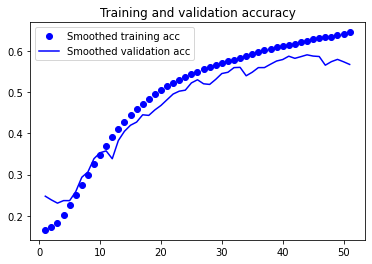

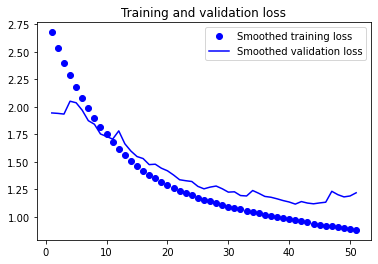

In [ ]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
epochs = range(1, len(loss2) + 1)

plt.plot(epochs,
         smooth_curve(acc2), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc2), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss2), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss2), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss2, test_acc2 = modelB.evaluate(x_public_generator, steps=97)
print('test acc:', test_acc2)

97/97 [==============================] - 1s 14ms/step - loss: 1.0653 - accuracy: 0.6113
test acc: 0.6113123297691345


##Comparison
* Compare the classification metrics and confusion matrices

In [ ]:
x_public_generator.reset()
predB = modelB.predict(x_public_generator)
y_predB = np.argmax(predB, axis=1)

In [ ]:
print('Confusion Matrices:')
print('\t\tBasic')
print(pd.DataFrame(confusion_matrix(y_PublicTest, y_pred)))

print('\n\t\tBalanced')
print(pd.DataFrame(confusion_matrix(y_PublicTest, y_predB)))


Confusion Matrices:
		Basic
     0   1    2    3    4    5    6
0  219   6   34   35   71   17   85
1   16  21    2    6    6    0    5
2   38   2  167   35  115   44   95
3   17   0   10  788   12   19   49
4   55   4   43   39  336   14  162
5   18   3   30   23    5  317   19
6   33   5   13   67  109   10  370

		Balanced
     0   1    2    3    4    5    6
0  241  12   33   13  108   12   48
1    4  35    1    3   11    0    2
2   57   7  130   10  195   43   54
3   32   7    8  679   61   21   87
4   58   5   25   10  464   10   81
5   13   2   30   13   22  319   16
6   37   0   13   29  198    4  326


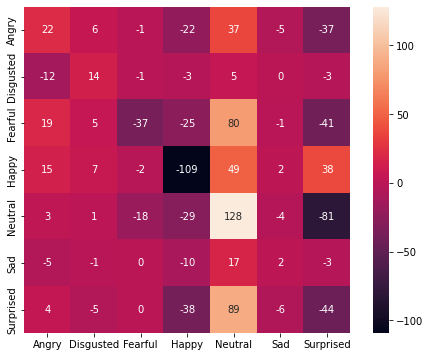

In [ ]:
plt.figure(figsize=(8,6))
bas_cm = pd.DataFrame(confusion_matrix(y_PublicTest, y_pred) )
bal_cm = pd.DataFrame(confusion_matrix(y_PublicTest, y_predB), dtype=np.dtype("float") )
res_cm = bal_cm.subtract(bas_cm, fill_value=0)



sns.heatmap(res_cm,annot=True,square=True,fmt='.0f',xticklabels=emotion_dict.values(),yticklabels=emotion_dict.values())


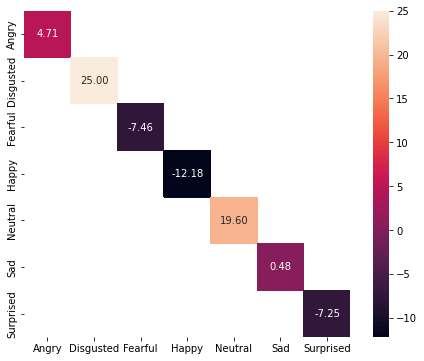

In [ ]:
sum =pd.DataFrame(y_PublicTest.value_counts())
sum.sort_index(inplace=True)
for i in range(7):
  res_cm.iat[i,i]=res_cm.iat[i,i]/ sum.iat[i,0]*100
plt.figure(figsize=(8,6))
mask = np.full((7,7),True)
mask[np.diag_indices_from(mask)] = False
sns.heatmap(res_cm,annot=True,square=True,fmt='2.2f',mask=mask, xticklabels=emotion_dict.values(),yticklabels=emotion_dict.values())


In [ ]:
print('Classification Reports:')
print('\t\t\tBasic')
print(classification_report(y_PublicTest, y_pred))
print('\t\t\tBalanced')
print(classification_report(y_PublicTest, y_predB))

Classification Reports:
			Basic
              precision    recall  f1-score   support

           0       0.55      0.47      0.51       467
           1       0.51      0.38      0.43        56
           2       0.56      0.34      0.42       496
           3       0.79      0.88      0.83       895
           4       0.51      0.51      0.51       653
           5       0.75      0.76      0.76       415
           6       0.47      0.61      0.53       607

    accuracy                           0.62      3589
   macro avg       0.59      0.56      0.57      3589
weighted avg       0.62      0.62      0.61      3589

			Balanced
              precision    recall  f1-score   support

           0       0.55      0.52      0.53       467
           1       0.51      0.62      0.56        56
           2       0.54      0.26      0.35       496
           3       0.90      0.76      0.82       895
           4       0.44      0.71      0.54       653
           5       0.78      0.77